# Trading Notebook
J Daniel Kim

Overall goal: Recently, there has been a rise of retail traders in the market. The purpose of this project is to create a easy to use equity trading service that helps take emotional decisions out of the factor. Also, I want to discover if my model could profit in the  2020.


MVP Goal:Fit baseline models such as ARIMA and VARIMAX.  Move onto fitting simple neural networks and LSTM's

Evaluation metrics: Accuracy,RMSE, MSE, MAE

In [1]:
#importing packages
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import requests
import pmdarima as pm
from statsmodels.tsa.api import VAR
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

#Transforming stock data
def yfinance_import(x):
    stock = yf.Ticker(x)
    hist = stock.history(period='max')
    return hist

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
#Transforming income dataset
def Income_statement(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns=['EBIT', 'TotalRevenue','\tNetIncome']
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    df = df[['EBIT', 'TotalRevenue','\tNetIncome']].astype(float)
    df.rename(columns={'\tNetIncome':'NetIncome'},inplace=True)
    return df.resample('D').ffill()['2005-01-01':]
    

In [3]:
#Transforming cashflow dataset
def cashflow_organize(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns=['FreeCashFlow','FinancingCashFlow','InvestingCashFlow','OperatingCashFlow']
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    df = df[['FreeCashFlow','FinancingCashFlow','InvestingCashFlow','OperatingCashFlow']].astype(float)
    return df.resample('D').ffill()['2005-01-01':]

In [4]:
#Transforming financials
def cleaning_valuation(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns = ['MarketCap', 'PeRatio']
    changing = ['MarketCap',  'PeRatio']
    df.drop(columns=['EnterpriseValue','EnterprisesValueRevenueRatio','EnterprisesValueEBITDARatio','PsRatio', 'PbRatio', 'ForwardPeRatio', 'PegRatio'],inplace=True)
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    for j in changing:
        df[j] = df[j].map(lambda x: float(x))
    return df.resample('D').ffill()['2005-01-01':]
    
        

In [5]:
#Transforming financials
def cleaning_valuation2(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns = ['MarketCap','PeRatio']
    changing = ['MarketCap', 'PeRatio']
    df.drop(columns=['EnterpriseValue', 'EnterprisesValueRevenueRatio','PsRatio', 'PbRatio', 'ForwardPeRatio', 'PegRatio'],inplace=True)
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    for j in changing:
        df[j] = df[j].map(lambda x: float(x))
    return df.resample('D').ffill()['2005-01-01':]
    
        

In [6]:
#Transforming financials
def cleaning_valuation3(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns = ['MarketCap','PeRatio']
    changing = ['MarketCap', 'PeRatio']
    df.drop(columns=['PsRatio', 'PbRatio', 'ForwardPeRatio', 'PegRatio'],inplace=True)
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    for j in changing:
        df[j] = df[j].map(lambda x: float(x))
    return df.resample('D').ffill()['2005-01-01':]
    
        

In [7]:
#Helping rename columns
def column_names(x):
    x.rename(columns={0:'Open', 1:'High', 2:'Low', 3:'Close', 4:'Volume', 5:'Dividends', 6:'MarketCap',
       7:'PeRatio', 8:'EBIT', 9:'TotalRevenue', 10:'NetIncome', 11:'FreeCashFlow',
       12:'FinancingCashFlow', 13:'InvestingCashFlow', 14:'OperatingCashFlow', 15:'mean'},inplace=True)
    return x

In [8]:
#Importing and scaling vix data
vix = pd.read_csv('vixcurrent.csv',header=1)
vix['mean'] = (vix['VIX High'] + vix['VIX Low'])/2
vix['Date'] = pd.to_datetime(vix['Date'], format="%m/%d/%Y")
vix.set_index('Date',inplace=True)
vix['mean']=vix['mean'].map(lambda x:-x)
vix = vix.ffill()
vix_mean = pd.DataFrame(vix['mean'])['2005-01-01':]

In [9]:
#Microsoft
MSFT_valuation = cleaning_valuation(pd.read_csv('MSFT/MSFT_monthly_valuation_measures.csv'))
MSFT_income_statement = Income_statement(pd.read_csv('MSFT/MSFT_quarterly_financials.csv'))
MSFT_cashflow = cashflow_organize(pd.read_csv('MSFT/MSFT_quarterly_cash-flow.csv'))
#APPLE
AAPL_valuation = cleaning_valuation(pd.read_csv('AAPL/AAPL_monthly_valuation_measures.csv'))
AAPL_cashflow = cashflow_organize(pd.read_csv('AAPL/AAPL_quarterly_cash-flow.csv'))
AAPL_income_statement = Income_statement(pd.read_csv('MSFT/MSFT_quarterly_financials.csv'))

#Amazon does not have dividends
AMZN_valuation = cleaning_valuation(pd.read_csv('AMZN/AMZN_monthly_valuation_measures.csv'))
AMZN_cashflow = cashflow_organize(pd.read_csv('AMZN/AMZN_quarterly_cash-flow.csv'))
AMZN_income_statement = Income_statement(pd.read_csv('AMZN/AMZN_quarterly_financials.csv'))

#JNJ
JNJ_valuation = cleaning_valuation(pd.read_csv('JNJ/JNJ_monthly_valuation_measures.csv'))
JNJ_cashflow = cashflow_organize(pd.read_csv('JNJ/JNJ_quarterly_cash-flow.csv'))
JNJ_income_statement = Income_statement(pd.read_csv('JNJ/JNJ_quarterly_financials.csv'))

#Visacard
V_valuation = cleaning_valuation(pd.read_csv('V/V_monthly_valuation_measures.csv'))
V_cashflow = cashflow_organize(pd.read_csv('V/V_quarterly_cash-flow.csv'))
V_income_statement = Income_statement(pd.read_csv('V/V_quarterly_financials.csv'))

#Facebook does not have dividends
FB_valuation = cleaning_valuation(pd.read_csv('FB/FB_monthly_valuation_measures.csv'))
FB_cashflow = cashflow_organize(pd.read_csv('FB/FB_quarterly_cash-flow.csv'))
FB_income_statement = Income_statement(pd.read_csv('FB/FB_quarterly_financials.csv'))

#Berkshire Hathway does not have dividends 
BRK_B_valuation = cleaning_valuation2(pd.read_csv('BRK-B/BRK-B_monthly_valuation_measures.csv'))
BRK_B_cashflow = cashflow_organize(pd.read_csv('BRK-B/BRK-B_quarterly_cash-flow.csv'))
BRK_B_income_statement = Income_statement(pd.read_csv('BRK-B/BRK-B_quarterly_financials.csv'))

#Berkshire Hathway does not have dividends
GOOGL_valuation = cleaning_valuation(pd.read_csv('GOOGL/GOOGL_monthly_valuation_measures.csv'))
GOOGL_cashflow = cashflow_organize(pd.read_csv('GOOGL/GOOGL_quarterly_cash-flow.csv'))
GOOGL_income_statement = Income_statement(pd.read_csv('GOOGL/GOOGL_quarterly_financials.csv'))

#JP Morgan
JPM_valuation = cleaning_valuation3(pd.read_csv('JPM/JPM_monthly_valuation_measures.csv'))
JPM_cashflow = cashflow_organize(pd.read_csv('JPM/JP_quarterly_cash-flow.csv'))
JPM_income_statement = Income_statement(pd.read_csv('JPM/JP_quarterly_financials.csv'))

#Proctor and gamble 
PG_valuation = cleaning_valuation(pd.read_csv('PG/PG_monthly_valuation_measures.csv'))
PG_cashflow = cashflow_organize(pd.read_csv('PG/PG_quarterly_cash-flow.csv'))
PG_income_statement = Income_statement(pd.read_csv('PG/PG_quarterly_financials.csv'))


In [10]:
#importing financial info
import yfinance as yf
AAPL = yfinance_import('AAPL').resample('D').ffill()['2005-01-01':] #1
MSFT = yfinance_import('MSFT').resample('D').ffill()['2005-01-01':]#2
AMZN = yfinance_import('AMZN').resample('D').ffill()['2005-01-01':]#3
JNJ = yfinance_import('JNJ').resample('D').ffill()['2005-01-01':]#4
V = yfinance_import('V').resample('D').ffill()['2005-01-01':]#5
FB = yfinance_import('FB')['2005-01-01':].resample('D').ffill()['2005-01-01':]#6
GOOGL = yfinance_import('GOOGL').resample('D').ffill()['2005-01-01':]#7
JPM = yfinance_import('JPM').resample('D').ffill()['2005-01-01':]#8
PG = yfinance_import('PG').resample('D').ffill()['2005-01-01':]#9
BRK_B = yfinance_import('BRK-B').resample('D').ffill()['2005-01-01':]#10

In [11]:
#dropping stock splits
AAPL.drop('Stock Splits',axis=1, inplace=True)
MSFT.drop('Stock Splits',axis=1, inplace=True)
AMZN.drop('Stock Splits',axis=1, inplace=True)
JNJ.drop('Stock Splits',axis=1, inplace=True)
V.drop('Stock Splits',axis=1, inplace=True)
FB.drop('Stock Splits',axis=1, inplace=True)
GOOGL.drop('Stock Splits',axis=1, inplace=True)
JPM.drop('Stock Splits',axis=1, inplace=True)
PG.drop('Stock Splits',axis=1, inplace=True)
BRK_B.drop('Stock Splits',axis=1, inplace=True)


In [12]:
#Concating all info
AAPL_concat = pd.concat([AAPL,AAPL_valuation,AAPL_income_statement,AAPL_cashflow,vix_mean],axis=1)
MSFT_concat = pd.concat([MSFT,MSFT_valuation,MSFT_income_statement,MSFT_cashflow,vix_mean],axis=1)
AMZN_concat = pd.concat([AMZN,AMZN_valuation,AMZN_income_statement,AMZN_cashflow,vix_mean],axis=1)
JNJ_concat = pd.concat([JNJ,JNJ_valuation,JNJ_income_statement,JNJ_cashflow,vix_mean],axis=1)
V_concat = pd.concat([V,V_valuation,V_income_statement,V_cashflow,vix_mean],axis=1)
FB_concat = pd.concat([FB,FB_valuation,FB_income_statement,FB_cashflow,vix_mean],axis=1)
GOOGL_concat = pd.concat([GOOGL,GOOGL_valuation,GOOGL_income_statement,GOOGL_cashflow,vix_mean],axis=1)
JPM_concat = pd.concat([JPM,JPM_valuation,JPM_income_statement,JPM_cashflow,vix_mean],axis=1)
PG_concat = pd.concat([PG,PG_valuation,PG_income_statement,PG_cashflow,vix_mean],axis=1)
BRK_B_concat = pd.concat([BRK_B,BRK_B_valuation,BRK_B_income_statement,BRK_B_cashflow,vix_mean],axis=1)


In [13]:
#Imputing values using InterpolateTime
def imputing_values(valuation,columns):
    import numpy as np
    for z in columns:
        valuation = valuation.assign(InterpolateTime=valuation[z].interpolate(method='time'))
        valuation[z]=valuation['InterpolateTime']
    valuation.drop('InterpolateTime',axis=1,inplace=True)
    return valuation.ffill()

In [14]:
#Imputing values
min_max_scaler = preprocessing.MinMaxScaler()
columns =['MarketCap', 'PeRatio','EBIT', 'TotalRevenue','NetIncome']
AAPL_concat = imputing_values(AAPL_concat,columns)
MSFT_concat = imputing_values(MSFT_concat,columns)
AMZN_concat = imputing_values(AMZN_concat,columns)
JNJ_concat = imputing_values(JNJ_concat,columns)
V_concat = imputing_values(V_concat,columns)
FB_concat = imputing_values(FB_concat,columns)
GOOGL_concat = imputing_values(GOOGL_concat,columns)
JPM_concat = imputing_values(JPM_concat,columns)
PG_concat = imputing_values(PG_concat,columns)
BRK_B_concat = imputing_values(BRK_B_concat,columns)

In [15]:
#scaled data and renaming columns
AAPL_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(AAPL_concat)))
MSFT_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(MSFT_concat)))
AMZN_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(AMZN_concat)))
JNJ_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(JNJ_concat)))
V_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(V_concat)))
FB_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(FB_concat)))
GOOGL_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(GOOGL_concat)))
JPM_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(JPM_concat)))
PG_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(PG_concat)))
BRK_B_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(BRK_B_concat)))


## EDA

#### Imputing

In the world of finance, the three financial statements release quartely or in their 8-k, which can be random. From this, we can help create our valuation metrics. However, as you can see in the plot below, that the reporting has missing values therefore not being to make the P/E ratio.

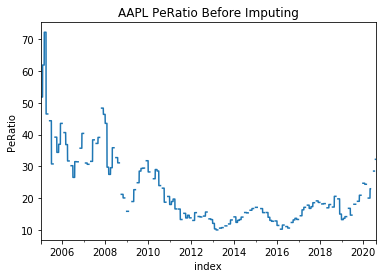

In [16]:
AAPL_valuation['PeRatio'].plot()
plt.title('AAPL PeRatio Before Imputing')
plt.ylabel('PeRatio')
plt.savefig('AAPL_PeRatio_Before_Imputing.png');

I have created a transformation that imputes the values using the Interpolate time method. This helps connect the dots. Below is an example after the imputing.

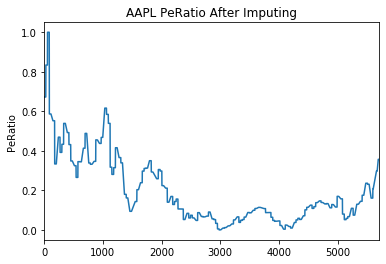

In [17]:
AAPL_scaled['PeRatio'].plot()
plt.title('AAPL PeRatio After Imputing')
plt.ylabel('PeRatio')
plt.savefig('AAPL_PeRatio_After_Imputing.png');

Here is another example of Microsoft. (First before and second after) 

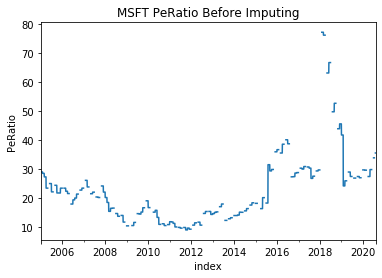

In [18]:
MSFT_valuation['PeRatio'].plot()
plt.title('MSFT PeRatio Before Imputing')
plt.ylabel('PeRatio')
plt.savefig('MSFT_PeRatio_Before_Imputing.png');

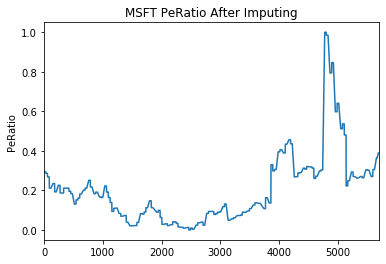

In [19]:
MSFT_scaled['PeRatio'].plot()
plt.title('MSFT PeRatio After Imputing')
plt.ylabel('PeRatio')
plt.savefig('MSFT_PeRatio_After_Imputing.png');

#### Heatmap Correlation

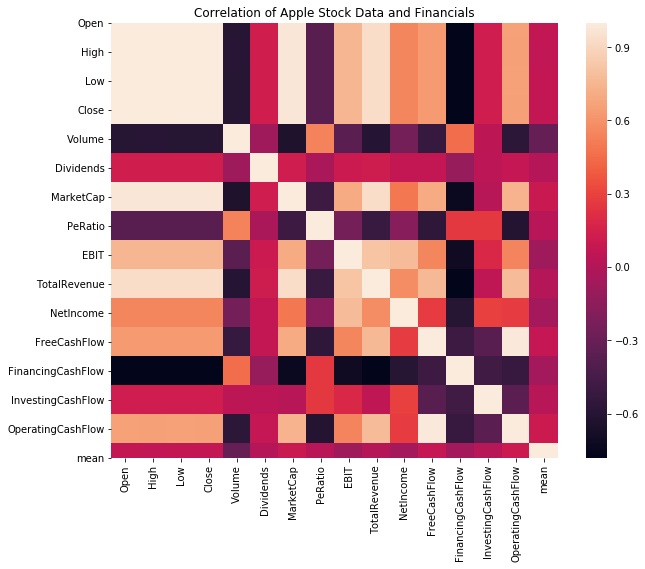

<Figure size 432x288 with 0 Axes>

In [20]:
data= AAPL_concat
fmapping, heatmapping = plt.subplots(figsize=(10, 8))
heatmapping= sns.heatmap(data.corr(), square=False)
heatmapping.set(title='Correlation of Apple Stock Data and Financials')
plt.show()
plt.savefig('Correlation_of_Apple_Stock_Data_and_Financials.png');

From this we can see that the stock data is highly correlated amongst each other as well as Total Revenue.

#### Looking at important dates and triggers of the market 2020

Dates:
- 2020-03-23: S&P hit their lowest point
- 2020-03-27: Stimulus package
- 2020-05-23: Memorial Day Weekend
- 2020-07-04: July 4th


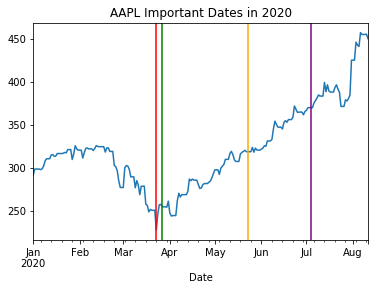

In [21]:
#APPLE
AAPL_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('AAPL Important Dates in 2020')
plt.savefig('AAPL_Important_Dates_in_2020.png');

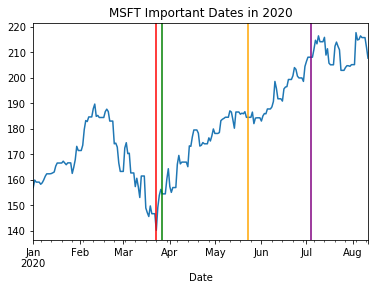

In [22]:
#Microsoft
MSFT_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('MSFT Important Dates in 2020')
plt.savefig('MSFT_Important_Dates_in_2020.png');

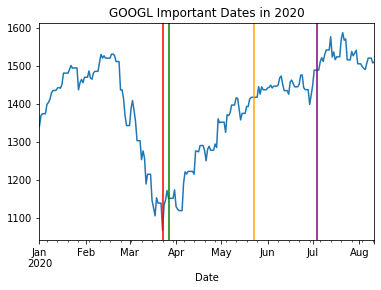

In [23]:
#GOOGLE
GOOGL_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('GOOGL Important Dates in 2020')
plt.savefig('GOOGL_Important_Dates_in_2020.png');

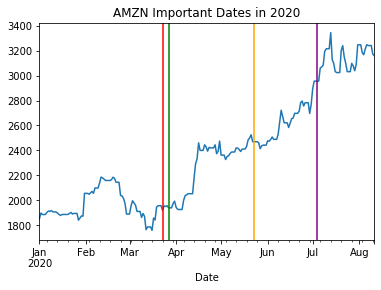

In [24]:
#Amazon 
AMZN_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('AMZN Important Dates in 2020')
plt.savefig('AMZN_Important_Dates_in_2020.png');

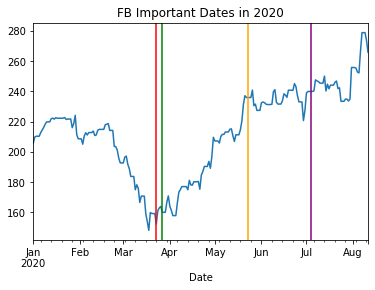

In [25]:
#Facebook 
FB_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('FB Important Dates in 2020')
plt.savefig('FB_Important_Dates_in_2020.png');

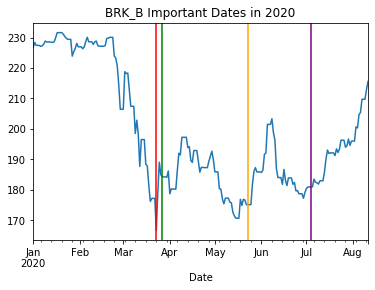

In [26]:
#Berkshire Hathaway
BRK_B_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('BRK_B Important Dates in 2020')
plt.savefig('BRK_B_Important_Dates_in_2020.png');

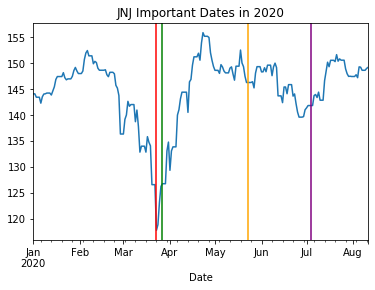

In [27]:
#Johnson and Johnson
JNJ_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('JNJ Important Dates in 2020');

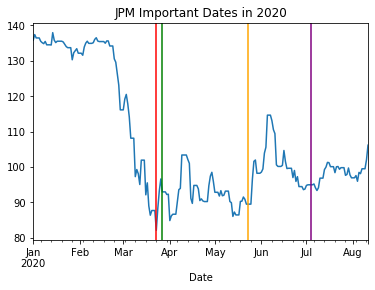

In [28]:
#JP. Morgan
JPM_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('JPM Important Dates in 2020')
plt.savefig('JPM_Important_Dates_in_2020.png');

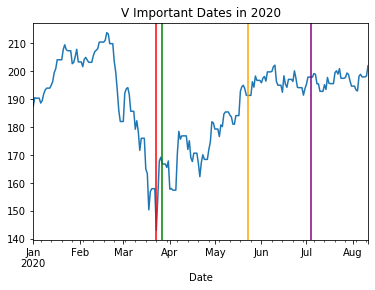

In [29]:
#Visa
V_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('V Important Dates in 2020')
plt.savefig('V_Important_Dates_in_2020.png');

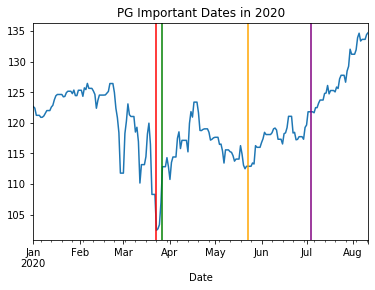

In [30]:
#Proctor and Gamble
PG_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('PG Important Dates in 2020')
plt.savefig('PG_Important_Dates_in_2020.png');

## Univariate single layer Neural network linear regression before HyperParameter


In [31]:
AAPL_concat.reset_index(inplace=True)

In [32]:
#Function for plotting series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [33]:
#Train test split and other parameters
time = np.arange(len(AAPL), dtype="float32")
series =AAPL_concat['Close']
x_train = np.array(AAPL_concat['Close'][:5478])
time_train = time[:5478]
x_valid = np.array(AAPL_concat['Close'][5478:])
time_valid = time[5478:]
split_time =5478
window_size = 2
batch_size = 34
shuffle_buffer_size = len(AAPL)
split_time = 5478

In [34]:
#Sliding windows and data transformation
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [35]:
#Fitting model
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape=[window_size])])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


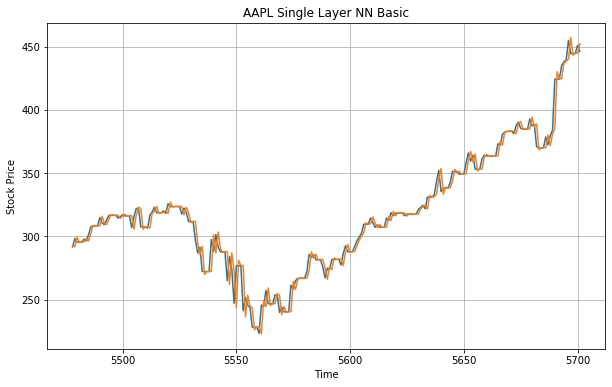

In [36]:
#Forcasting
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(np.array(series[time:time + window_size])[np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.ylabel('Stock Price')
plt.title('AAPL Single Layer NN Basic')
plt.savefig('AAPL_Single_Layer_NN_Basic.png');

In [37]:
#Prepping for valuation method
changes_x_valid = pd.DataFrame(x_valid).pct_change().astype(float)[1:]
changes_x_valid.rename(columns={0:'valid'},inplace=True)
changes_results = pd.DataFrame(results).pct_change().astype(float)[1:]
changes_results.rename(columns={0:'result'},inplace=True)
changes = pd.concat([changes_x_valid,changes_results],axis=1)

In [38]:
#MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8630056

In [39]:
#RMSE
np.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

8.042859

In [40]:
#MSE
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

64.68758

Below I convert the results to percent change. If the output is positive then I go long and if negative then I short. For now I will only use the long only option so in this case 1 is long and 0 is other. I then create an aggregating percent change to find the growth perspective of this stock and use the binary outcome to create an accuracy score.

In [41]:
#Prepping for percent change conversion
results = pd.DataFrame(results)
results.rename(columns={0:'results'},inplace=True)
results= results.pct_change()
results['long_predict'] = results.results.map(lambda x: True if x>0 else False)
x_valid_test = pd.DataFrame(x_valid)
x_valid_test.rename(columns={0:'valid'},inplace=True)
x_valid_test= x_valid_test.pct_change()
x_valid_test['long_true'] = x_valid_test.valid.map(lambda x: True if x>0 else False)

Long Only

In [42]:
#Long
growth = pd.concat([results,x_valid_test],axis=1)
true_false = growth[(growth['long_true']>=0)&(growth['long_predict']==1)]
true_false['aggregate_percentage'] = true_false['valid'].map(lambda x: 1+x)


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [43]:
#Long counting
count = 1
for i in true_false['aggregate_percentage']:
    count*=i

In [44]:
count

0.8496154982358392

If you use the long only fund then you will lose 15.1% for AAPL stock


In [45]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(results.drop('results',axis=1), x_valid_test.drop('valid',axis=1))

array([[64, 55],
       [75, 30]])

In [46]:
#Accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(results.drop('results',axis=1), x_valid_test.drop('valid',axis=1))

0.41964285714285715

## Univariate single layer Neural network linear regression AAPL (Changed epoch and learning rate) 


In [47]:
#Train Test Split
time = np.arange(len(AAPL), dtype="float32")
series =AAPL_concat['Close']
x_train = np.array(AAPL_concat['Close'][:5478])
time_train = time[:5478]
x_valid = np.array(AAPL_concat['Close'][5478:])
time_valid = time[5478:]
split_time =5478
window_size = 2
batch_size = 34
shuffle_buffer_size = len(AAPL)
split_time = 5478

In [48]:
#Fitting the data
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape=[window_size])])
model.compile(loss="mse", optimizer='adam')
model.fit(dataset,epochs=110,verbose=0,shuffle=False)


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


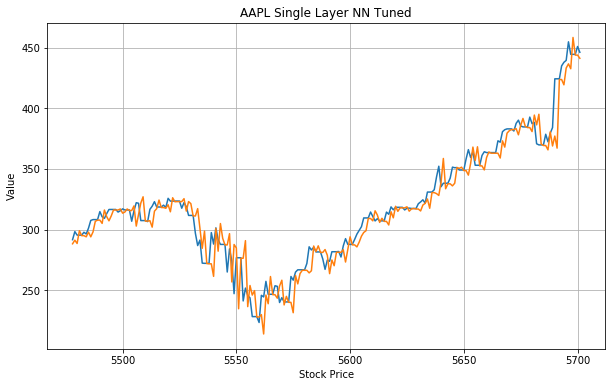

In [49]:
#Forcasting the data
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(np.array(series[time:time + window_size])[np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.xlabel('Stock Price')
plt.title('AAPL Single Layer NN Tuned')
plt.savefig('AAPL_Single_Layer_NN_Tuned.png');

In [50]:
#Prepping for valuation method
changes_x_valid = pd.DataFrame(x_valid).pct_change().astype(float)[1:]
changes_x_valid.rename(columns={0:'valid'},inplace=True)
changes_results = pd.DataFrame(results).pct_change().astype(float)[1:]
changes_results.rename(columns={0:'result'},inplace=True)
changes = pd.concat([changes_x_valid,changes_results],axis=1)

In [51]:
#MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.023298

In [52]:
#RMSE
np.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

12.141463

In [53]:
#MSE
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

147.41513

In [54]:
#Prepping for long and short
results = pd.DataFrame(results)
results.rename(columns={0:'results'},inplace=True)
results= results.pct_change()
results['long_predict'] = results.results.map(lambda x: True if x>0 else False)
x_valid_test = pd.DataFrame(x_valid)
x_valid_test.rename(columns={0:'valid'},inplace=True)
x_valid_test= x_valid_test.pct_change()
x_valid_test['long_true'] = x_valid_test.valid.map(lambda x: True if x>0 else False)

Long Only

In [55]:
#Long
growth = pd.concat([results,x_valid_test],axis=1)
true_false = growth[(growth['long_true']>=0)&(growth['long_predict']==1)]
true_false['aggregate_percentage'] = true_false['valid'].map(lambda x: 1+x)


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [56]:
#Long counting
count = 1
for i in true_false['aggregate_percentage']:
    count*=i

In [57]:
count

1.5366481494593212

If you use the long only fund then you will see returns of 53.4% for AAPL Stock


In [58]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(results.drop('results',axis=1), x_valid_test.drop('valid',axis=1))

array([[82, 46],
       [57, 39]])

In [59]:
#Accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(results.drop('results',axis=1), x_valid_test.drop('valid',axis=1))

0.5401785714285714

## Univariate single layer Neural network linear regression AMZN (Changed epoch and learning rate) 


In [60]:
AMZN_concat.reset_index(inplace=True)

In [61]:
#Train Test Split
time = np.arange(len(AMZN), dtype="float32")
series =AMZN_concat['Close']
x_train = np.array(AMZN_concat['Close'][:5478])
time_train = time[:5478]
x_valid = np.array(AMZN_concat['Close'][5478:])
time_valid = time[5478:]
split_time =5478
window_size = 2
batch_size = 34
shuffle_buffer_size = len(AMZN)
split_time = 5478

In [62]:
#Fitting the data
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape=[window_size])])
model.compile(loss="mse", optimizer='adam')
model.fit(dataset,epochs=110,verbose=0,shuffle=False)


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


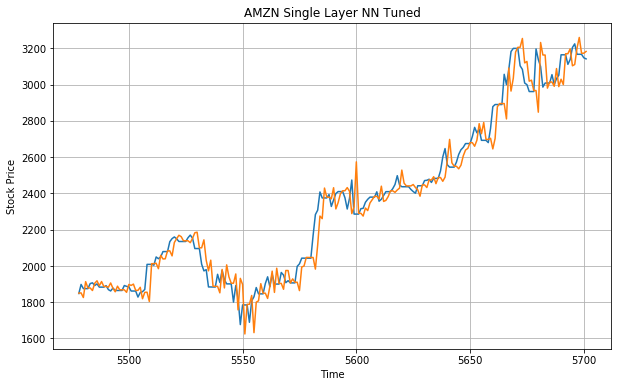

In [63]:
#Forcasting the data
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(np.array(series[time:time + window_size])[np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.ylabel('Stock Price')
plt.title('AMZN Single Layer NN Tuned')
plt.savefig('AMZN_Single_Layer_NN_Tuned.png');

In [64]:
#Prepping for valuation method
changes_x_valid = pd.DataFrame(x_valid).pct_change().astype(float)[1:]
changes_x_valid.rename(columns={0:'valid'},inplace=True)
changes_results = pd.DataFrame(results).pct_change().astype(float)[1:]
changes_results.rename(columns={0:'result'},inplace=True)
changes = pd.concat([changes_x_valid,changes_results],axis=1)

In [65]:
#MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

57.32503

In [66]:
#RMSE
np.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

84.02224

In [67]:
#MSE
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

7059.737

In [68]:
#Prepping for long and short
results = pd.DataFrame(results)
results.rename(columns={0:'results'},inplace=True)
results= results.pct_change()
results['long_predict'] = results.results.map(lambda x: True if x>0 else False)
x_valid_test = pd.DataFrame(x_valid)
x_valid_test.rename(columns={0:'valid'},inplace=True)
x_valid_test= x_valid_test.pct_change()
x_valid_test['long_true'] = x_valid_test.valid.map(lambda x: True if x>0 else False)

Long Only

In [69]:
#Long
growth = pd.concat([results,x_valid_test],axis=1)
true_false = growth[(growth['long_true']>=0)&(growth['long_predict']==1)]
true_false['aggregate_percentage'] = true_false['valid'].map(lambda x: 1+x)


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [70]:
#Long counting
count = 1
for i in true_false['aggregate_percentage']:
    count*=i

In [71]:
count

1.2564872402602556

If you ran this model you should see returns of 25.6% for AAPL stock

In [72]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(results.drop('results',axis=1), x_valid_test.drop('valid',axis=1))

array([[73, 51],
       [62, 38]])

In [73]:
#Accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(results.drop('results',axis=1), x_valid_test.drop('valid',axis=1))

0.4955357142857143

## Univariate LSTM Time series model AAPL Bidirectional

In [74]:
#Train Test Split
x_train = pd.DataFrame(AAPL_scaled['Close']).rename(columns={0:'Close'})[:5478]
x_test= pd.DataFrame(AAPL_scaled['Close']).rename(columns={0:'Close'})[5478:]

In [75]:
#Transforming dataset 
def creat_dataset(X,y,time_steps=1):
    Xs, ys =[],[]
    for i in range(len(X)-time_steps):
        v=X.iloc[i:(i+time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [76]:
#More Train Test Split
TIME_STEPS = 2
X_train, y_train = creat_dataset(x_train, x_train['Close'], time_steps=TIME_STEPS)
X_test, y_test = creat_dataset(x_test, x_test['Close'], time_steps=TIME_STEPS)

In [77]:
#Modeling and predicting
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train, epochs = 50, batch_size=30,shuffle=False)
y_pred=model.predict(X_test)
y_predicting_values = pd.DataFrame(y_pred.reshape(1,-1)).T
y_test_values = pd.DataFrame(y_test.reshape(1,-1)).T

Epoch 1/50
5476/5476 [==============================] - 1s 199us/sample - loss: 3.0276e-04
Epoch 2/50
5476/5476 [==============================] - 1s 115us/sample - loss: 0.0019
Epoch 3/50
5476/5476 [==============================] - 1s 114us/sample - loss: 4.7186e-04
Epoch 4/50
5476/5476 [==============================] - 1s 110us/sample - loss: 4.0737e-05
Epoch 5/50
5476/5476 [==============================] - 1s 111us/sample - loss: 1.6393e-05
Epoch 6/50
5476/5476 [==============================] - 1s 107us/sample - loss: 2.3734e-05
Epoch 7/50
5476/5476 [==============================] - 1s 110us/sample - loss: 2.3044e-05
Epoch 8/50
5476/5476 [==============================] - 1s 106us/sample - loss: 1.9488e-05
Epoch 9/50
5476/5476 [==============================] - 1s 115us/sample - loss: 1.4708e-05
Epoch 10/50
5476/5476 [==============================] - 1s 111us/sample - loss: 1.2104e-05
Epoch 11/50
5476/5476 [==============================] - 1s 111us/sample - loss: 1.2250e-05
E

In [78]:
y_predicting_values.rename(columns={0:'predict'},inplace=True)
y_test_values.rename(columns={0:'result'},inplace=True)

In [79]:
y_values_compare = pd.concat([y_predicting_values,y_test_values],axis=1) 

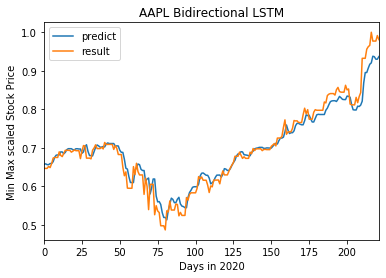

In [80]:
y_values_compare.plot()
plt.xlabel('Days in 2020')
plt.ylabel('Min Max scaled Stock Price')
plt.title('AAPL Bidirectional LSTM')
plt.savefig('AAPL_Bidirectional_LSTM.png');

In [81]:
#MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_values, y_predicting_values)

0.0005603609543697632

In [82]:
#RMSE
np.sqrt(mean_squared_error(y_test_values, y_predicting_values))

0.023671944456883198

In [83]:
#Define function for MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [84]:
#MAE
from sklearn.metrics import mean_absolute_error
np.sqrt(mean_absolute_error(y_test_values, y_predicting_values))


0.1286428324871132

In [85]:
#MAPE
mean_absolute_percentage_error(y_test_values, y_predicting_values)

0.02395493310054296

In [86]:
#Classifying long as 1 and short as 0
y_test_pct_change = y_test_values.pct_change()
y_test_pct_change['long_true'] = y_test_pct_change.result.map(lambda x: True if x>=0 else False)
y_predicting_values_pct_change = y_predicting_values.pct_change()
y_predicting_values_pct_change['long_predict'] = y_predicting_values_pct_change.predict.map(lambda x: True if x>=0 else False)


In [87]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pct_change.drop('result',axis=1), y_predicting_values_pct_change.drop('predict',axis=1))

array([[17, 51],
       [62, 92]])

In [88]:
#Accuracy Score
from sklearn.metrics import accuracy_score
accuracy_score(y_test_pct_change.drop('result',axis=1), y_predicting_values_pct_change.drop('predict',axis=1))

0.49099099099099097

In [89]:
#Prepping data to find the growth rate
actua1 = AAPL_concat['Close'][5479:-1]
actual = pd.DataFrame(actua1.reset_index()).drop('index',axis=1)
growth = pd.concat([y_test_pct_change,y_predicting_values_pct_change,actual],axis=1)
true_false = growth[(growth['long_true']>=0)&(growth['long_predict']==1)]
true_false['aggregate_percentage'] = true_false['result'].map(lambda x: 1+x)

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
count = 1
for i in true_false['aggregate_percentage']:
    count*=i

In [91]:
count

1.144869439127528

With this model you should see a return on the AAPL stock of 14.5%

## Univariate LSTM Time series model AMZN Bidirectional

In [92]:
#Train Test Split
x_train = pd.DataFrame(AMZN_scaled['Close']).rename(columns={0:'Close'})[:5478]
x_test= pd.DataFrame(AMZN_scaled['Close']).rename(columns={0:'Close'})[5478:]

In [93]:
#Transforming dataset 
def creat_dataset(X,y,time_steps=1):
    Xs, ys =[],[]
    for i in range(len(X)-time_steps):
        v=X.iloc[i:(i+time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [94]:
#More Train Test Split
TIME_STEPS = 2
X_train, y_train = creat_dataset(x_train, x_train['Close'], time_steps=TIME_STEPS)
X_test, y_test = creat_dataset(x_test, x_test['Close'], time_steps=TIME_STEPS)

In [95]:
#MOdeling and predicting
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train, epochs = 50, batch_size=30,shuffle=False)
y_pred=model.predict(X_test)
y_predicting_values = pd.DataFrame(y_pred.reshape(1,-1)).T
y_test_values = pd.DataFrame(y_test.reshape(1,-1)).T

Epoch 1/50
5476/5476 [==============================] - 1s 198us/sample - loss: 2.9844e-04
Epoch 2/50
5476/5476 [==============================] - 1s 115us/sample - loss: 0.0016s - loss
Epoch 3/50
5476/5476 [==============================] - 1s 116us/sample - loss: 0.0022
Epoch 4/50
5476/5476 [==============================] - 1s 112us/sample - loss: 0.0022
Epoch 5/50
5476/5476 [==============================] - 1s 111us/sample - loss: 0.0023
Epoch 6/50
5476/5476 [==============================] - 1s 112us/sample - loss: 0.0019
Epoch 7/50
5476/5476 [==============================] - 1s 114us/sample - loss: 9.9973e-04
Epoch 8/50
5476/5476 [==============================] - 1s 117us/sample - loss: 3.8903e-04
Epoch 9/50
5476/5476 [==============================] - 1s 118us/sample - loss: 1.1228e-04
Epoch 10/50
5476/5476 [==============================] - 1s 114us/sample - loss: 4.3511e-05
Epoch 11/50
5476/5476 [==============================] - 1s 122us/sample - loss: 2.9726e-05
Epoch 12/

In [96]:
y_predicting_values.rename(columns={0:'predict'},inplace=True)
y_test_values.rename(columns={0:'result'},inplace=True)

In [97]:
y_values_compare = pd.concat([y_predicting_values,y_test_values],axis=1) 

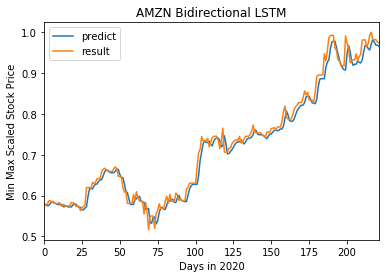

In [98]:
y_values_compare.plot()
plt.title('AMZN Bidirectional LSTM')
plt.xlabel('Days in 2020')
plt.ylabel('Min Max Scaled Stock Price')
plt.savefig('AMZN_Bidirectional_LSTM.png');

In [99]:
#MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_values, y_predicting_values)

0.000324199086078833

In [100]:
#RMSE
np.sqrt(mean_squared_error(y_test_values, y_predicting_values))

0.01800552931959605

In [101]:
#MAE
from sklearn.metrics import mean_absolute_error
np.sqrt(mean_absolute_error(y_test_values, y_predicting_values))


0.11201918583879376

In [102]:
#MAPE
mean_absolute_percentage_error(y_test_values, y_predicting_values)

0.017089206543615895

In [103]:
#Classifying long as 1 and short as 0
y_test_pct_change = y_test_values.pct_change()
y_test_pct_change['long_true'] = y_test_pct_change.result.map(lambda x: True if x>=0 else False)
y_predicting_values_pct_change = y_predicting_values.pct_change()
y_predicting_values_pct_change['long_predict'] = y_predicting_values_pct_change.predict.map(lambda x: True if x>=0 else False)


In [104]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pct_change.drop('result',axis=1), y_predicting_values_pct_change.drop('predict',axis=1))

array([[22, 43],
       [60, 97]])

In [105]:
#Accuracy Score
from sklearn.metrics import accuracy_score
accuracy_score(y_test_pct_change.drop('result',axis=1), y_predicting_values_pct_change.drop('predict',axis=1))

0.536036036036036

In [106]:
#Prepping data to find the growth rate
actua1 = AMZN_concat['Close'][5479:-1]
actual = pd.DataFrame(actua1.reset_index()).drop('index',axis=1)
growth = pd.concat([y_test_pct_change,y_predicting_values_pct_change,actual],axis=1)
true_false = growth[(growth['long_true']>=0)&(growth['long_predict']==1)]
true_false['aggregate_percentage'] = true_false['result'].map(lambda x: 1+x)

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
count = 1
for i in true_false['aggregate_percentage']:
    count*=i
count

1.420810533970976

If you run this model on AMZN then you should see returns of 42.1%

## VARIMAX MODEL AAPL

Fitted a simple varimax model (Multivariate)

In [108]:
#Train Test Split
time = np.arange(5478, dtype="float32")
series =np.array(AAPL_scaled)
x_train_endog = AAPL_concat[['Open', 'High', 'Low', 'Close', 'Dividends', 'MarketCap','PeRatio', 'EBIT', 'TotalRevenue', 'NetIncome']][:5458]
time_train = time[:5478]
x_valid_endog = AAPL_concat[['Open', 'High', 'Low', 'Close', 'Dividends', 'MarketCap','PeRatio', 'EBIT', 'TotalRevenue', 'NetIncome']][5458:]
time_valid = time[5478:]
split_time =5478
window_size = 20
batch_size = 16
shuffle_buffer_size = len(AAPL)
split_time = 5478

In [109]:
#Fitting and model prediction
from statsmodels.tsa.api import VAR
model = VAR(endog=x_train_endog)
model_fit = model.fit()
prediction = model_fit.forecast(model_fit.y, steps=len(x_valid_endog))
prediction = pd.DataFrame(prediction)

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [110]:
prediction.rename(columns={0:'Open', 1:'High', 2:'Low', 3:'Close', 4:'Dividends', 5:'MarketCap',6:'PeRatio', 7:'EBIT', 8:'TotalRevenue', 9:'NetIncome'},inplace=True)

In [111]:
#Changing x_valid_endog into a dataframe
x_valid_endog = pd.DataFrame(x_valid_endog['Close'])
x_valid_endog.reset_index(inplace=True)
x_valid_endog.drop('index',axis=1,inplace=True)

In [112]:
#RMSE
np.sqrt(tf.keras.metrics.mean_squared_error(x_valid_endog['Close'], prediction['Close']).numpy())

48.42410851367743

In [113]:
#MSE
tf.keras.metrics.mean_squared_error(x_valid_endog['Close'], prediction['Close']).numpy()

2344.894285344407

In [114]:
#MAE
np.sqrt(mean_absolute_error(x_valid_endog['Close'], prediction['Close']))

6.154029336129379

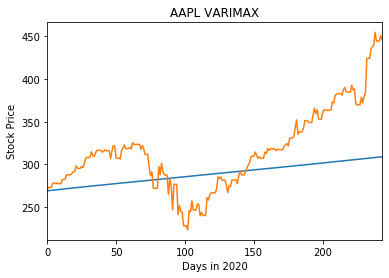

In [115]:
prediction['Close'].plot()
x_valid_endog['Close'].plot()
plt.xlabel('Days in 2020')
plt.ylabel('Stock Price')
plt.title('AAPL VARIMAX')
plt.savefig('AAPL_VARIMAX.png');

## Arimax Basic Tuning AAPL

In [116]:
#Train Test Split
x_train_endog = AAPL['Close'][:5478]
x_valid_endog = AAPL['Close'][5478:]

In [117]:
#Fitting Sarimax model
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(endog = x_train_endog, order=(1,1,1))
res = mod.fit(disp=False)
pred_confirmed = res.predict()

In [118]:
#RMSE Training
np.sqrt(mean_squared_error(x_train_endog, pred_confirmed))

1.2599311710617234

In [122]:
#Predicting parameters testing
predict_start_date = 5479
predict_end_date = len(AAPL)
predict__confirmed_testing = res.predict(start=predict_start_date, end=predict_end_date)

In [123]:
#RMSE Testing
np.sqrt(mean_squared_error(pd.DataFrame(x_valid_endog),pd.DataFrame(predict__confirmed_testing)))

55.26708280893387

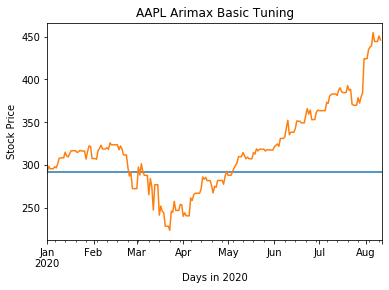

In [124]:
#Plot
predict__confirmed_testing.plot()
x_valid_endog.plot()
plt.xlabel('Days in 2020')
plt.ylabel('Stock Price')
plt.title('AAPL Arimax Basic Tuning')
plt.savefig('AAPL_Arimax_Basic_Tuning.png');

## Arimax Model Tuning AAPL

In [132]:
#Train Test Split
x_train_endog = AAPL['Close'][:5478]
x_valid_endog = AAPL['Close'][5478:]

In [133]:
#Fitting Sarimax model
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(endog = x_train_endog, order=(3,2,1))
res = mod.fit(disp=False)

In [134]:
#Predicting
pred_confirmed = res.predict()

In [135]:
#RMSE Training
np.sqrt(mean_squared_error(x_train_endog, pred_confirmed))


1.257844380099342

In [136]:
#Predicting parameters testing
predict_start_date = 5479
predict_end_date = len(AAPL)
predict__confirmed_testing = res.predict(start=predict_start_date, end=predict_end_date)

In [137]:
#RMSE Testing
np.sqrt(mean_squared_error(x_valid_endog, predict__confirmed_testing))

40.29194936322515

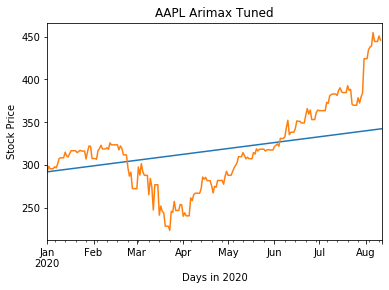

In [138]:
#Plot
predict__confirmed_testing.plot()
x_valid_endog.plot()
plt.xlabel('Days in 2020')
plt.ylabel('Stock Price')
plt.title('AAPL Arimax Tuned')
plt.savefig('AAPL_Arimax_Tuned.png');

Future Goals: Fit onto all 10 stocks, create a pipeline, create a attention layer LSTM